# Statistic analysis

This notebook is used to analyse the data of the multiple runs on our model. Multiple methods for cleaning the data are described below. Next, the data is analysed using the seaborn package.

In [10]:
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import os

print('Import of packages succeeded!')

Import of packages succeeded!


### Methods for importing the data

In [2]:
def load_plot_archive(path):
    """
    Loads the data from the experiment into RAM
    
    returns:
        - keys df
        - df
    """
    file_path = [path]

    for path in file_path:
        with open(path, 'rb') as f:
            data = np.load(f, allow_pickle=True)[()]
    
    keys = data.keys()
    return keys, data

In [63]:
def create_df_list(keys, df):
    """
    Creates a list of dataframes
    
    Returns:
        - df list
    """

    df_list = []
    for key in keys:
      
        appendable_df = df[key]
        appendable_df = appendable_df[(appendable_df.index + 1)% 2 != 0].reset_index(drop=True)
        df_list.append(appendable_df)
        
    return df_list

### Method for rearranging the data

This method rearranges the data in a pandas dataframe. It returns three arrays: peak size, duration and amount of outbreaks per run.

In [4]:
def get_outbreaks(data, threshold=50):
    """
    Calculates the outbreaks from the actives data.

    Returns:
        - An array with the outbreak peak sizes.
        - An array with the outbreak durations.
        - An array of the outbreaks
    """
    outbreak_peaks = []
    outbreak_widths = []
    counting = False
    current_peak = 0
    start = 0

    for i in range(len(data)):

        if data[i] >= threshold and not counting:
            counting = True
            if current_peak < data[i]:
                current_peak = data[i]
            start = i

        elif data[i] >= threshold and counting:
            if current_peak < data[i]:
                current_peak = data[i]

        elif data[i] < threshold and counting:
            outbreak_peaks.append(current_peak)
            outbreak_widths.append(i-start)
            current_peak = 0
            counting = False

    # Capture cases where timeline ends in an outbreak.
    # Obviously skewers data, but preferable over 0 or infinite outbreaks.
    if not outbreak_peaks and counting:
        outbreak_peaks.append(current_peak)
        outbreak_widths.append(len(data))
    elif not outbreak_peaks and not counting:
        outbreak_peaks.append(0)
        outbreak_widths.append(0)

    return outbreak_peaks, outbreak_widths, list(range(len(outbreak_peaks)))

In [5]:
def create_peakduration_df(name, data):
    """
    Creates a dataframe of the data

    Returns:
        - Pandas.DataFrame Object 
        - list of outbreaks per run
    """

    total_peaks = []
    total_durations = []
    total_outbreak_numbers = []
    average_outbreaks = []
    
    for df in df_list:
        peaks , durations, outbreak_numbers = get_outbreaks(df.ACTIVE)
        total_peaks += peaks
        total_durations += durations
        total_outbreak_numbers += outbreak_numbers
        average_outbreaks.append(len(durations))

    df = pd.DataFrame(data={'PeakHeight': total_peaks, 
                            'PeakDuration': total_durations, 
                            'OutbreakNumber': total_outbreak_numbers})
    df["Network"] = name
    
    outbreaks_df = pd.DataFrame(data={'OutbreaksPerRun': average_outbreaks})
    outbreaks_df["Network"] = name
    
    return df, outbreaks_df

In [6]:
def read_filenames(directory):
    """
    Reads the different filenames of a directory
    
    returns:
        - filenames
    """    
    return [directory + name for name in os.listdir(directory)]

Special method developped to adjust the data based on a certain condition

In [7]:
def drop_rows_df(df, columnname, condition):
    """
    Drops rows based on a condition
    
    returns:
        - dataframe
    """
    return df[df[columnname] != condition]

# Analysis

1. Import of data
2. Cleaning and rearranging data
3. Merging data into one dataframe

In [71]:
path = '../archives/data/'
filenames = read_filenames(path)
names = [file.split('_')[5] for file in filenames]

full_df = pd.DataFrame()
full_outbreaks_df = pd.DataFrame()

for index in range(len(filenames)):
    
    keys, total_file_df = load_plot_archive(filenames[index])
    df_list = create_df_list(keys, total_file_df)
    df_plot, df_outbreaks_per_run = create_peakduration_df(names[index], df_list)
    full_df = pd.concat([full_df, df_plot])
    full_outbreaks_df = pd.concat([full_outbreaks_df, df_outbreaks_per_run])

full_df = drop_rows_df(full_df, 'PeakDuration', 201)
full_outbreaks_df = drop_rows_df(full_outbreaks_df, 'OutbreaksPerRun', 1)
print(full_df)
print(full_outbreaks_df)

     PeakHeight  PeakDuration  OutbreakNumber      Network
0           510            14               0         None
1           300            11               1         None
2           318            12               2         None
3           187             9               3         None
4           285            10               4         None
..          ...           ...             ...          ...
118         790            21               0  ERDOS-RENYI
119         699            20               1  ERDOS-RENYI
120         751            20               2  ERDOS-RENYI
121         695            21               3  ERDOS-RENYI
122         543            20               4  ERDOS-RENYI

[780 rows x 4 columns]
    OutbreaksPerRun      Network
0                 8         None
1                 6         None
2                 8         None
3                 9         None
4                 8         None
..              ...          ...
31                4  ERDOS-RENYI
33  

# Experiment 1:

Experiment 1 was about comparing the behaviour of the different networks in comparison with a model where no network was implemented. 

In [72]:
# Drop the rows of experiment 2
df_exp1 = drop_rows_df(full_df, 'Network', 'BARABASI-ALBERT-influencer')
print(df_exp1)
dfOutbreaks_exp1 = drop_rows_df(full_outbreaks_df, 'Network', 'BARABASI-ALBERT-influencer')
print(dfOutbreaks_exp1)



     PeakHeight  PeakDuration  OutbreakNumber      Network
0           510            14               0         None
1           300            11               1         None
2           318            12               2         None
3           187             9               3         None
4           285            10               4         None
..          ...           ...             ...          ...
118         790            21               0  ERDOS-RENYI
119         699            20               1  ERDOS-RENYI
120         751            20               2  ERDOS-RENYI
121         695            21               3  ERDOS-RENYI
122         543            20               4  ERDOS-RENYI

[642 rows x 4 columns]
    OutbreaksPerRun      Network
0                 8         None
1                 6         None
2                 8         None
3                 9         None
4                 8         None
..              ...          ...
31                4  ERDOS-RENYI
33  

### PeakHeight

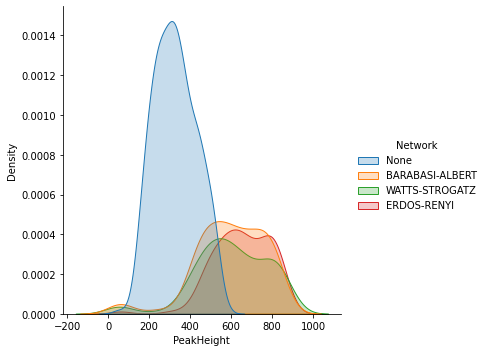

In [73]:
sns.displot(df_exp1, x="PeakHeight", hue='Network', fill=True, kind='kde')

The distributions show a bimodal distributions. After some analysis, we determined that the first outbreak in each run caused the bimodal distributions. After deleting these from the data a normal-distribution was found.

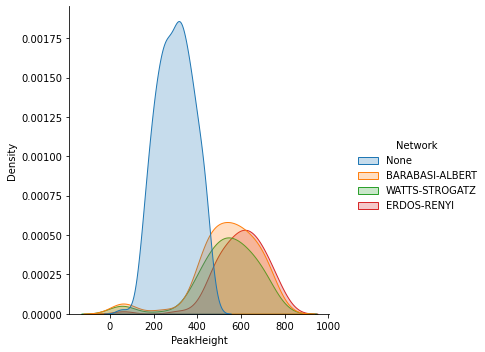

In [74]:
# Removing the first outbreak from the data
df_exp1_withoutPeak = drop_rows_df(df_exp1, 'OutbreakNumber', 0)
df_exp1_withoutPeak
sns.displot(df_exp1_withoutPeak, x="PeakHeight", hue='Network', fill=True, kind='kde')

### PeakDuration

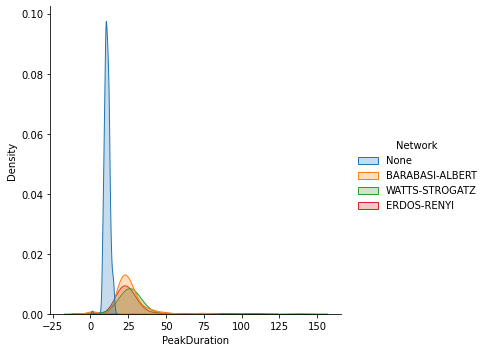

In [75]:
sns.displot(df_exp1, x="PeakDuration", hue='Network', fill=True, kind='kde')

No bimodal distribution was found when it came to the peakduration. However, the above figure is difficult to interpret due the high peak of the runs without the network. Therefore, these runs were removed for the next figure.

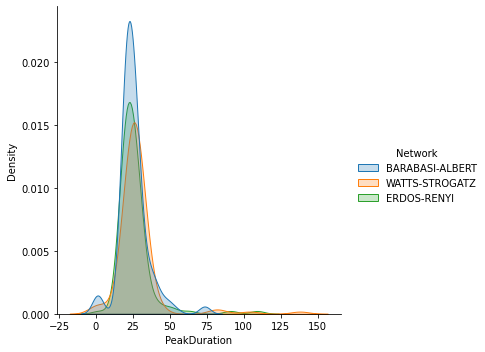

In [76]:
# Removing the runs without network
df_exp1_withoutNone = drop_rows_df(df_exp1, 'Network', 'None')
df_exp1_withoutNone
sns.displot(df_exp1_withoutNone, x="PeakDuration", hue='Network', fill=True, kind='kde')

A clear difference between the Barabasi-Albert network and the other two networks is now observed.

### OutbreakPerRun

Lastly, we tried to see if there was any difference between the outbreaks per run of 200 timesteps.

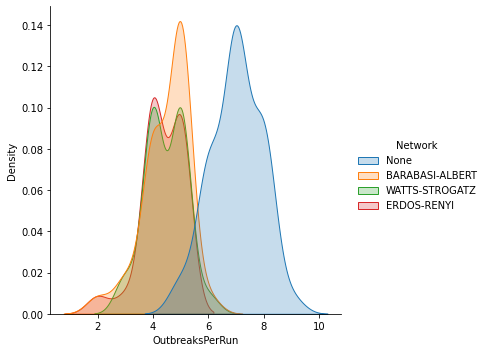

In [77]:
sns.displot(dfOutbreaks_exp1, x='OutbreaksPerRun', hue='Network', fill=True, kind='kde')

When it comes to the outbreaks per run, we can conclude the same as before. The runs without network implement behave significant different, then runs were there is a network implemented. However, the multiple network implementations do not differ much.

# Experiment 2:

In experiment 2 we tried to remove influencers from the grid. Influencers were agents with more than 150 connections.

In [31]:
# Drop the rows of experiment 1
df_exp2 = drop_rows_df(full_df, 'Network', 'None')
df_exp2 = drop_rows_df(df_exp2, 'Network', 'ERDOS-RENYI')
df_exp2 = drop_rows_df(df_exp2, 'Network', 'WATTS-STROGATZ')
print(df_exp2)

dfOutbreaks_exp2 = drop_rows_df(full_outbreaks_df, 'Network', 'None')
dfOutbreaks_exp2 = drop_rows_df(dfOutbreaks_exp2, 'Network', 'ERDOS-RENYI')
dfOutbreaks_exp2 = drop_rows_df(dfOutbreaks_exp2, 'Network', 'WATTS-STROGATZ')
print(dfOutbreaks_exp2)

     PeakHeight  PeakDuration  OutbreakNumber                     Network
0           786            58               0             BARABASI-ALBERT
1           445            76               1             BARABASI-ALBERT
2           507            58               2             BARABASI-ALBERT
3           430            70               3             BARABASI-ALBERT
4           833           401               0             BARABASI-ALBERT
..          ...           ...             ...                         ...
160         519            46               3  BARABASI-ALBERT-influencer
161          50             1               4  BARABASI-ALBERT-influencer
162         490            44               5  BARABASI-ALBERT-influencer
163          52             1               6  BARABASI-ALBERT-influencer
164         546            48               7  BARABASI-ALBERT-influencer

[313 rows x 4 columns]
    OutbreaksPerRun                     Network
0                 4             BARABASI

In [9]:
temp = drop_rows_df(df_without_1, 'Network', 'BARABASI-ALBERT-influencer')
sns.displot(temp, x="PeakHeight", hue='Network', fill=True, kind='kde')
plt.savefig('WithoutRemoveInfluencerDensity')
sns.displot(temp, x='PeakDuration', hue='Network', fill=True, kind='kde')

NameError: name 'df_without_1' is not defined

In [ ]:
full_outbreaks_df
full_outbreaks_df = drop_rows_df(full_outbreaks_df, 'OutbreaksPerRun', 1)
sns.boxplot(x='Network', y='OutbreaksPerRun', data=full_outbreaks_df)
sns.displot(full_outbreaks_df, x="OutbreaksPerRun", hue='Network', fill=True, kind='kde')

In [ ]:
sns.scatterplot(data=full_df, x="PeakDuration", y="PeakHeight", hue="Network")

In [ ]:
sns.boxplot(x='Network', y='PeakDuration', data=full_df)
plt.show()
sns.boxplot(x='Network', y='PeakHeight', data=full_df)

In [ ]:
full_df
df_without_1 = drop_rows_df(full_df, 'OutbreakNumber', 0)

# full_df = drop_rows_df(full_df, 'PeakDuration', 401)

In [ ]:
sns.displot(df_without_1, x="PeakHeight", hue='Network', fill=True, kind='kde')
plt.savefig('withoud_bimodal.png')

In [ ]:
only2df = drop_rows_df(full_df, 'PeakDuration', 401)
only2df = drop_rows_df(only2df, 'Network', 'WATTS-STROGATZ')
only2df = drop_rows_df(only2df, 'Network', 'ERDOS-RENYI')
only2df = drop_rows_df(only2df, 'Network', 'None')
only2df = drop_rows_df(only2df, 'OutbreakNumber', 0)

sns.boxplot(x='Network', y='PeakHeight', data=only2df)
plt.show()
sns.boxplot(x='Network', y='PeakDuration', data=only2df)
sns.displot(only2df, x="PeakHeight", hue='Network', fill=True, kind='kde')
plt.savefig('only2density.png')
